In [68]:
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [73]:
def ret_victory_home(row):
    if row['goal1'] > row['goal2']:
        return 'победа'
    elif row['goal1'] < row['goal2']:
        return 'поражение'
    else:
        return 'ничья'
    
def ret_victory_guest(row):
    if row['goal1'] > row['goal2']:
        return 'поражение'
    elif row['goal1'] < row['goal2']:
        return 'победа'
    else:
        return 'ничья'

Загружаем таблицы

In [144]:
countries = pd.read_csv('countries.csv')
players = pd.read_csv('players.csv')
events_df = pd.read_csv('events.csv')

Правим таблицы

In [5]:
countries.columns = ['country_id', 'country']
players.columns = ['num', 'name', 'team', 'birthdate', 'pos', 'country_id']
players = players.merge(countries, on='country_id')
players['birthdate'] = pd.to_datetime(players['birthdate'], format='%d-%m-%Y')
players['age'] = ((dt.datetime.now() - players['birthdate']).dt.days / 365).apply(np.floor)

In [6]:
players.head()

,num,name,team,birthdate,pos,country_id,country,age
0,1,Мануэль Нойер,Бавария,1986-03-27,врт,1,Германия,38.0
1,12,Оливер Бауман,Хоффенхайм,1990-06-02,врт,1,Германия,34.0
2,22,Марк-Андре тер Стеген,Барселона,1992-04-30,врт,1,Германия,32.0
3,2,Антонио Рюдигер,Реал Мадрид,1993-03-03,зщ,1,Германия,31.0
4,3,Давид Раум,РБ Лейпциг,1998-04-22,зщ,1,Германия,26.0


## Предварительная статистика

In [7]:
(players.
 pivot_table(index='team', values='num', aggfunc='count').
 sort_values(by='num', ascending=False).
 head(10)
)

,num
team,
Интер Милан,13
Манчестер Сити,13
Пари Сен-Жермен,12
Реал Мадрид,12
РБ Лейпциг,11
Барселона,11
Арсенал,10
Славия (Прага),10
Байер 04,10


### Возраст игроков

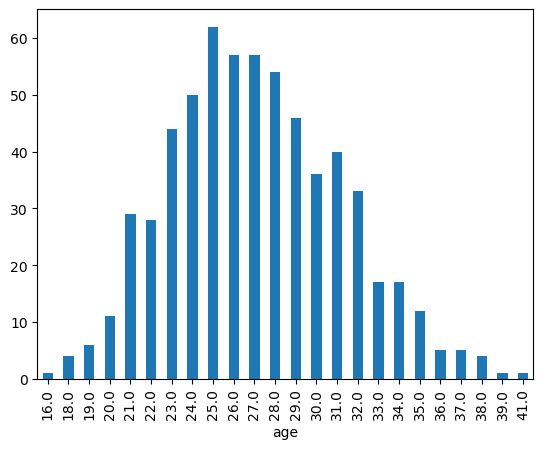

In [8]:
players.groupby('age')['num'].count().plot(kind='bar');

In [9]:
players['age'].describe()

count    620.000000
mean      27.109677
std        4.124975
min       16.000000
25%       24.000000
50%       27.000000
75%       30.000000
max       41.000000
Name: age, dtype: float64

Самые возрастные игроки

In [10]:
players.sort_values(by='birthdate').head(5)

,num,name,team,birthdate,pos,country_id,country,age
572,3,Пепе,Порту,1983-02-26,защ,23,Португалия,41.0
587,7,Криштиану Роналду,Ан-Наср (Эр-Рияд),1985-02-05,нап,23,Португалия,39.0
143,10,Лука Модрич,Реал Мадрид,1985-09-09,поз,6,Хорватия,38.0
113,22,Хесус Навас,Севилья,1985-11-21,защ,5,Испания,38.0
542,1,Георгий Лория,Динамо Тбилиси,1986-01-27,врт,22,Грузия,38.0


Самые молодые игроки

In [11]:
players.sort_values(by='birthdate', ascending=False).head(5)

,num,name,team,birthdate,pos,country_id,country,age
127,19,Ламин Ямаль,Барселона,2007-07-13,нап,5,Испания,16.0
403,18,Варрен Заир-Эмри,Пари Сен-Жермен,2006-03-08,поз,16,Франция,18.0
462,24,Лео Сауэр,Фейеноорд,2005-12-16,нап,18,Словакия,18.0
539,24,Семих Кылычсой,Бешикташ,2005-08-15,нап,21,Турция,18.0
559,26,Габриэль Сигуа,Базель,2005-06-30,поз,22,Грузия,18.0


Самые возрастные команды

In [12]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age', ascending=False).head(5)

,age
country,
Германия,28.576923
Шотландия,28.307692
Польша,28.208333
Хорватия,27.730769
Дания,27.730769


Самые молодые команды

In [13]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age').head(5)

,age
country,
Чехия,25.500000
Турция,25.807692
Англия,26.076923
Нидерланды,26.230769
Украина,26.384615


## Статистика турнира

### Бомбардиры

In [140]:
scorers = events_df[events_df['event'].isin(['гол','пенальти'])]
scorers.pivot_table(index='name', values='event', aggfunc='count')

,event
name,
Джамал Мусиала,1
Кай Хаверц,1
Флориан Вирц,1


### Ассистены

In [141]:
assisters = events_df[events_df['event']=='пас']
assisters.pivot_table(index='name', values='event', aggfunc='count')

,event
name,
Йозуа Киммих,1
Кай Хаверц,1


### Карточки

In [142]:
yellows = events_df[events_df['event']=='желтая карточка']
yellows.pivot_table(index='name', values='event', aggfunc='count')

,event
name,
Роберт Андрих,1
Энтони Ралстон,1


In [143]:
reds = events_df[events_df['event']=='красная карточка']
reds.pivot_table(index='name', values='event', aggfunc='count')

,event
name,
Райан Портеус,1


## Старые игры

In [85]:
old_games = pd.read_csv('old_games.csv')
old_games.columns = ['game_id', 'date', 'team1', 'team2', 'goal1', 'goal2', 'description'] 
old_games['date'] = pd.to_datetime(old_games['date'], format='%d-%m-%Y')

In [83]:
old_games.head()

,game_id,date,team1,team2,goal1,goal2,description
0,0,2021-06-11,Турция,Италия,0,3,ЧЕ-2020 Группа A тур 1
1,1,2021-06-12,Уэльс,Швейцария,1,1,ЧЕ-2020 Группа A тур 1
2,2,2021-06-12,Дания,Финляндия,0,1,ЧЕ-2020 Группа B тур 1
3,3,2021-06-12,Бельгия,Россия,3,0,ЧЕ-2020 Группа B тур 1
4,4,2021-06-13,Англия,Хорватия,1,0,ЧЕ-2020 Группа D тур 1


In [54]:
old_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   game_id      164 non-null    int64         
 1   date         164 non-null    datetime64[ns]
 2   team1        164 non-null    object        
 3   team2        164 non-null    object        
 4   goal1        164 non-null    int64         
 5   goal2        164 non-null    int64         
 6   description  164 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 9.1+ KB


**Введите названия команд**

In [111]:
team1='Германия'
team2='Шотландия'

**Игры между собой**

In [112]:
old_games.loc[((old_games['team1'] == team1) & (old_games['team2'] == team2)) 
              | ((old_games['team1'] == team2) & (old_games['team2'] == team1))]

,game_id,date,team1,team2,goal1,goal2,description


**Игры домашней команды**

In [113]:
team1h_df = old_games[old_games['team1'] == team1]
team1h_df['result'] = team1h_df.apply(ret_victory_home, axis=1)
display(team1h_df)
team1h_pivot = team1h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1g_df = old_games[old_games['team2'] == team1]
team1g_df['result'] = team1g_df.apply(ret_victory_guest, axis=1)
display(team1g_df)
team1g_pivot = team1g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1_pivot=team1h_pivot.merge(team1g_pivot, on='result', how='outer')
team1_pivot = team1_pivot.fillna(0)
team1_pivot['total'] = team1_pivot['game_id_x'] + team1_pivot['game_id_y']
team1_pivot.columns = ['home', 'guest', 'total']
team1_pivot[['home', 'guest', 'total']] = team1_pivot[['home', 'guest', 'total']].astype('int')
team1_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
35,35,2021-06-23,Германия,Венгрия,2,2,ЧЕ-2020 Группа F тур 3,ничья
64,64,2016-06-12,Германия,Украина,2,0,ЧЕ-2016 Группа C тур 1,победа
66,66,2016-06-16,Германия,Польша,0,0,ЧЕ-2016 Группа C тур 2,ничья
91,91,2016-06-26,Германия,Словакия,3,0,ЧЕ-2016 1/8 финала,победа
97,97,2016-07-02,Германия,Италия,1,1,пен 6 : 5 ЧЕ-2016 1/4 финала,ничья
100,100,2016-07-07,Германия,Франция,0,2,ЧЕ-2016 1/2 финала,поражение
109,109,2012-06-09,Германия,Португалия,1,0,ЧЕ-2012 Группа B тур 1,победа
127,127,2012-06-22,Германия,Греция,4,2,ЧЕ-2012 1/4 финала,победа
131,131,2012-06-28,Германия,Италия,1,2,ЧЕ-2012 1/2 финала,поражение
140,140,2008-06-08,Германия,Польша,2,0,ЧЕ-2008 Группа B тур 1,победа


,game_id,date,team1,team2,goal1,goal2,description,result
11,11,2021-06-15,Франция,Германия,1,0,ЧЕ-2020 Группа F тур 1,поражение
22,22,2021-06-19,Португалия,Германия,2,4,ЧЕ-2020 Группа F тур 2,победа
42,42,2021-06-29,Англия,Германия,2,0,ЧЕ-2020 1/8 финала,поражение
68,68,2016-06-21,Северная Ирландия,Германия,0,1,ЧЕ-2016 Группа C тур 3,победа
111,111,2012-06-13,Нидерланды,Германия,1,2,ЧЕ-2012 Группа B тур 2,победа
113,113,2012-06-17,Дания,Германия,1,2,ЧЕ-2012 Группа B тур 3,победа
141,141,2008-06-12,Хорватия,Германия,2,1,ЧЕ-2008 Группа B тур 2,поражение
143,143,2008-06-16,Австрия,Германия,0,1,ЧЕ-2008 Группа B тур 3,победа
157,157,2008-06-19,Португалия,Германия,2,3,ЧЕ-2008 1/4 финала,победа


,home,guest,total
result,,,
ничья,3,0,3
победа,6,6,12
поражение,3,3,6


**Игры гостевой команды**

In [119]:
team2h_df = old_games[old_games['team1'] == team2]
team2h_df['result'] = team2h_df.apply(ret_victory_home, axis=1)
display(team2h_df)
team2h_pivot = team2h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2g_df = old_games[old_games['team2'] == team2]
team2g_df['result'] = team2g_df.apply(ret_victory_guest, axis=1)
display(team2g_df)
team2g_pivot = team2g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2_pivot=team2h_pivot.merge(team2g_pivot, on='result', how='outer')
team2_pivot = team2_pivot.fillna(0)
team2_pivot['total'] = team2_pivot['game_id_x'] + team2_pivot['game_id_y']
team2_pivot.columns = ['home', 'guest', 'total']
team2_pivot[['home', 'guest', 'total']] = team2_pivot[['home', 'guest', 'total']].astype('int')
team2_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
7,7,2021-06-14,Шотландия,Чехия,0,2,ЧЕ-2020 Группа D тур 1,поражение


,game_id,date,team1,team2,goal1,goal2,description,result
20,20,2021-06-18,Англия,Шотландия,0,0,ЧЕ-2020 Группа D тур 2,ничья
30,30,2021-06-22,Хорватия,Шотландия,3,1,ЧЕ-2020 Группа D тур 3,поражение


,home,guest,total
result,,,
поражение,1,1,2
ничья,0,1,1


### Разное

In [111]:
uteams = players['team'].unique()
uteams.sort()
uteams

array(['АЕК Афины', 'АПОЭЛ', 'Айнтрахт Франкфурт', 'Академия Пушкаша',
       'Алавес', 'Аланьяспор', 'Аль-Ахли (Джидда)', 'Аль-Иттифак',
       'Аль-Иттихад', 'Аль-Муайдар', 'Аль-Ухдуд', 'Аль-Хиляль',
       'Ан-Наср (Эр-Рияд)', 'Андерлехт', 'Антальяспор', 'Арсенал',
       'Асколи', 'Астон Вилла', 'Аталанта', 'Атланта Юнайтед',
       'Атлетик Бильбао', 'Атлетико Мадрид', 'Аугсбург',
       'Аш-Шабаб (Эр-Рияд)', 'Аякс', 'Бавария', 'Базель', 'Байер 04',
       'Бани Яс', 'Баник (Острава)', 'Бари', 'Барселона', 'Бенфика',
       'Бернли', 'Бешикташ', 'Боавишта', 'Болонья', 'Бордо', 'Борнмут',
       'Боруссия Дортмунд', 'Боруссия Мёнхенгладбах', 'Бохум',
       'Брайтон энд Хоув Альбион', 'Брентфорд', 'Бристоль Сити',
       'Брондбю', 'Брюгге', 'Будё-Глимт', 'Вайле', 'Валенсия', 'Вердер',
       'Вест Бромвич Альбион', 'Вест Хэм Юнайтед', 'Вестерло',
       'Виктория (Пльзень)', 'Вильярреал', 'Волунтари', 'Вольфсберг',
       'Вольфсбург', 'Вулверхэмптон Уондерерс', 'Гавр', 'Газиантеп

In [112]:
len(uteams)

219

In [101]:
players[players['team'].str.contains('Спартак Трнава')]

,num,name,team,birthdate,pos,country_id,country,age
227,25,Адриан Зелькович,Спартак Трнава,2002-08-19,поз,9,Словения,21.0
